In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere_dg import mesh_hsphere
from pyCaMOtk.create_mesh_hcube_dg import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct

#有限元空间改成dg
from pyCaMOtk.create_femsp_dg import create_femsp_dg

from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalPossion, analyticalConeInterpolation
from GCNNModel import e2vcg2connectivity,PossionNet
#计算残差改成dg格式
from TensorFEMCore_dg import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)

c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


In [2]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=500

# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=PossionNet().to(device)
model=model.double()
										
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=2 # Polywwwnomial order for solution and geometry basis
nel=[2,2] # Number of element in x and y axis

lims = np.array([[-1, 1], [-1, 1]]) # Domain limits
msh=mesh_hsphere(etype,c,r,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 

connectivity=e2vcg2connectivity(msh.e2vcg,'intra') # Extract element connectivity
#输出一下e2vcg

self.nsd 2
f2cg [[ 0.  0.  2.  2.  4. 12. 12. 14. 14. 16. 24. 26.]
 [ 1.  6.  3.  8. 10. 13. 18. 15. 20. 22. 25. 27.]
 [ 2. 12.  4. 14. 16. 14. 24. 16. 26. 28. 26. 28.]]
[[[nan  0. nan  2.]
  [nan  2. nan  2.]]

 [[nan nan  0.  1.]
  [nan nan  3.  3.]]

 [[ 1. nan  3. nan]
  [ 0. nan  0. nan]]

 [[ 2.  3. nan nan]
  [ 1.  1. nan nan]]]
self.e2vcg0 [[ 0  2 12 14]
 [ 1  3 13 15]
 [ 2  4 14 16]
 [ 6  8 18 20]
 [ 7  9 19 21]
 [ 8 10 20 22]
 [12 14 24 26]
 [13 15 25 27]
 [14 16 26 28]]
self.nsd 2
f2cg [[ 0.  0.  2.  2.  4. 12. 12. 14. 14. 16. 24. 26.]
 [ 1.  6.  3.  8. 10. 13. 18. 15. 20. 22. 25. 27.]
 [ 2. 12.  4. 14. 16. 14. 24. 16. 26. 28. 26. 28.]]
[[[nan  0. nan  2.]
  [nan  2. nan  2.]]

 [[nan nan  0.  1.]
  [nan nan  3.  3.]]

 [[ 1. nan  3. nan]
  [ 0. nan  0. nan]]

 [[ 2.  3. nan nan]
  [ 1.  1. nan nan]]]
self.e2vcg0 [[ 0  2 12 14]
 [ 1  3 13 15]
 [ 2  4 14 16]
 [ 6  8 18 20]
 [ 7  9 19 21]
 [ 8 10 20 22]
 [12 14 24 26]
 [13 15 25 27]
 [14 16 26 28]]
NnG: 36
NnE: 4
Nrow: 9


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\GCNNModel.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.from_numpy(np.asarray(connectivity).T).to('cuda'), dtype=torch.long)


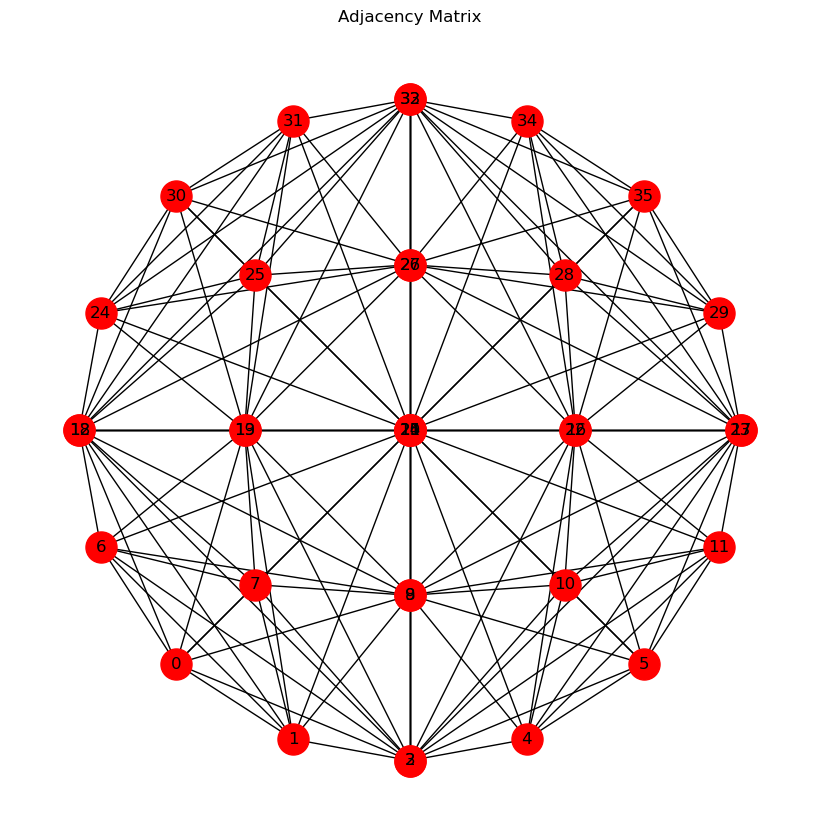

In [3]:
#绘制节点和邻接矩阵的示意图（connectivity是邻接矩阵）
edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)

pos = {i: (xcg[0, i], xcg[1, i]) for i in range(xcg.shape[1])}
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='r', node_size=500, font_size=12)
plt.title('Adjacency Matrix')
plt.show()

In [4]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]])
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 
Qb=lambda x,n,bnd,el,fc: 0 # The primary variable value on the boundary
dbc_idx=[i for i in range(xcg.shape[1]) if np.sum(xcg[:,i]**2)>1-1e-12] # The boundary node id
dbc_idx=np.asarray(dbc_idx) 
dbc_val=dbc_idx*0 # The boundary node primary variable value
Ufem=analyticalPossion(xcg,2).flatten().reshape(ndof,1)

idx_whole=[i for i in range(ndof) if i not in dbc_idx]
obsidx=np.asarray([8])
obsxcg=msh.xcg[:,obsidx]

dbc_idx_new=np.hstack((np.asarray(dbc_idx),obsidx))
dbc_val_new=Ufem[dbc_idx_new]
dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx_new,dbc_val_new) # Create the class of boundary condition


Src_new=model.source
K_new=torch.tensor([[1],[0],[0],[1]]).to('cuda').double().reshape((4,))
parsfuncI=lambda x: torch.cat((K_new,Src_new),axis=0)


In [5]:
S=[2] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc)
	femsp=create_femsp_dg(prob,msh,porder,porder)
	fcn=lambda u_:create_fem_resjac('cg',u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)

# Define the Training Data
Graph=[]
ii=0
for i in S:
	Ue=Double(analyticalPossion(xcg,i).flatten().reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)
print(Uin)

tensor([[-0.7071, -0.7071],
        [-0.3536, -0.9354],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.3536, -0.9354],
        [ 0.7071, -0.7071],
        [-0.9354, -0.3536],
        [-0.4677, -0.4677],
        [ 0.0000, -0.5000],
        [ 0.0000, -0.5000],
        [ 0.4677, -0.4677],
        [ 0.9354, -0.3536],
        [-1.0000,  0.0000],
        [-0.5000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.5000,  0.0000],
        [ 1.0000,  0.0000],
        [-1.0000,  0.0000],
        [-0.5000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.5000,  0.0000],
        [ 1.0000,  0.0000],
        [-0.9354,  0.3536],
        [-0.4677,  0.4677],
        [ 0.0000,  0.5000],
        [ 0.0000,  0.5000],
        [ 0.4677,  0.4677],
        [ 0.9354,  0.3536],
        [-0.7071,  0.7071],
        [-0.3536,  0.9354],
        [ 0.0000,  1.0000],
        [ 0.0000,  1.0000],
        [ 0.3536,  0.9354],
        [ 0.7071,  0

C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore_dg.py:467: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor([A]).reshape([1,1]).double().to('cuda')
c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
#检查自由度矩阵
print(femsp.ldof2gdof_eqn.ldof2gdof)
#从原来的共用单元边界25个自由度 变成现在36个自由度

[[ 0  3 18 21]
 [ 1  4 19 22]
 [ 2  5 20 23]
 [ 6  9 24 27]
 [ 7 10 25 28]
 [ 8 11 26 29]
 [12 15 30 33]
 [13 16 31 34]
 [14 17 32 35]]


epoch =  0


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore.py:324: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  return torch.reshape(input.T,[Shape[len(Shape)-1-i] \
C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore_dg.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re2_ = torch.tensor(Re2_,device=Re0_.device)
C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore_dg.py:54: UserWarning

Max Rf =============================== tensor(1.8718, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
reint= tensor(1.8970, device='cuda:0', dtype=torch.float64)
wallclock time of evl Res=  0.2727787494659424
max Res= 1.8717752609025866
wallclock time of this BP=  0.09438323974609375
>>>>>>>max error<<<<<<< ==================================== 0.9689003961660879
>>>>>>>model source<<<<<<< ======================= Parameter containing:
tensor([0.2500], device='cuda:0', dtype=torch.float64, requires_grad=True)
Solution er =  0.9689003961660879
The training reaches the expected loss!
epoch =  1
Max Rf =============================== tensor(0.8330, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
reint= tensor(1.1017, device='cuda:0', dtype=torch.float64)
wallclock time of evl Res=  0.1441030502319336
max Res= 0.8329985408219972
wallclock time of this BP=  0.039525747299194336
>>>>>>>max error<<<<<<< ==================================== 0.4274226015227597
>>>>>>>m

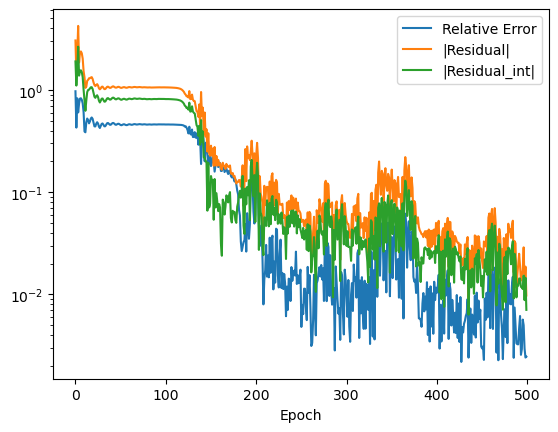

wallclock time of all epochs =  96.91540765762329
K= <function <lambda> at 0x0000013E8041E9D0>
Min Error= 0.002186248853067099
Mean Error Last 10 iterations= 0.0038076628531662437
Var  Error Last 10 iterations= 1.829844993238486e-06


In [7]:
[model,info]=solve_fem_GCNN(TrainDataloader,LossF,model,tol,maxit)
print('K=',K)
print('Min Error=',info['Er'].min())
print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))
torch.save(model, './modelCircleDet.pth')
np.save('modelCircleDet.npy',info)
solution=model(Graph[0].to('cuda'))
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()
Ue=Ue.detach().cpu().numpy()

In [11]:
solution_1=model(Graph[0].to('cuda'))
solution_1[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution_1=solution_1.detach().cpu().numpy()
print(msh.e2vcg.shape)

(9, 4)


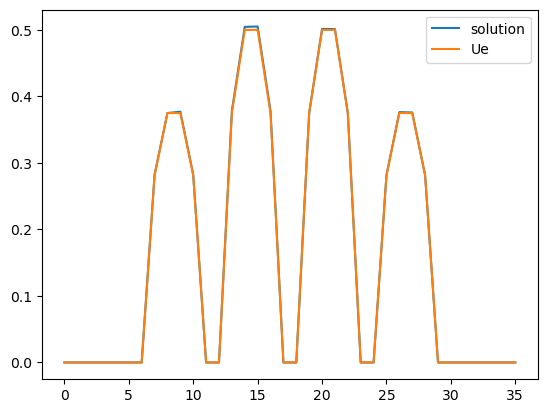

In [12]:
#直接绘制一下solution 和 Ue的值的差，横轴是0-36节点编号，纵轴是solution和Ue的差
plt.plot(solution)
plt.plot(Ue)
#图例
plt.legend(['solution','Ue'])
plt.show()

